# Higher-Order Neural ODEs

Following [Dissecting Neural ODEs](www.aaaa.com), In this tutorial we showcase how to handle **higher-order neural ODEs** in `torchdyn`

A higher--order neural ODEs can be simply defined as the initial value problem 

$$
    \begin{aligned}
        &\frac{d^n \mathbf{z}}{ds^n} = f_\theta\left(s, \mathbf{x}, \mathbf{z}, \frac{d \mathbf{z}}{ds}, \frac{d^2 \mathbf{z}}{ds^2}, \dots, \frac{d^{n-1} \mathbf{z}}{ds^{n-1}}\right)\\
        &\mathbf{z}(0), \frac{d \mathbf{z}}{ds}(0), \frac{d^2 \mathbf{z}}{ds^2}(0), \dots, \frac{d^{n-1} \mathbf{z}}{ds^{n-1}}(0) = h_{\mathbf{x}}(\mathbf{x})\\
        &{\bf y} = h_{\bf y}\left(\mathbf{z}(S), \frac{d \mathbf{z}}{ds}(S), \frac{d^2 \mathbf{z}}{ds^2}(S), \dots, \frac{d^{n-1} \mathbf{z}}{ds^{n-1}}(S)\right)
    \end{aligned}
$$

In [1]:
import sys
sys.path.append('../')
from torchdyn.models import *
from torchdyn import *
from torchdyn.datasets import *

**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve the binary classification problem.



In [2]:
d = ToyDataset()
X, yn = d.generate(n_samples=2048, dataset_type='spirals', noise=.4)

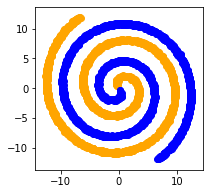

In [3]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

In [4]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

**Learner**

In [5]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        y_hat = self.model(x)  
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

### Train a simple Second-Order Model 

Second order models have also been considered by [CITE]

We can train out of the box a 2nd order model for classification as follows

In [6]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(4, 64),
        nn.Tanh(), 
        nn.Linear(64, 2))

# Neural ODE
model = NeuralDE(f, 
                 order=2,
                 solver='dopri5', 
                 sensitivity='adjoint').to(device)

seq = nn.Sequential(Augmenter(1, 2, order='last'), model, nn.Linear(4, 2)).to(device)

In [7]:
# train the neural ODE
learn = Learner(seq)
trainer = pl.Trainer(min_epochs=600, max_epochs=1200)
trainer.fit(learn)

INFO:lightning:
  | Name               | Type       | Params
----------------------------------------------
0 | model              | Sequential | 460   
1 | model.0            | Augmenter  | 0     
2 | model.1            | NeuralDE   | 450   
3 | model.1.defunc     | DEFunc     | 450   
4 | model.1.defunc.m   | Sequential | 450   
5 | model.1.defunc.m.0 | Linear     | 320   
6 | model.1.defunc.m.1 | Tanh       | 0     
7 | model.1.defunc.m.2 | Linear     | 130   
8 | model.1.adjoint    | Adjoint    | 0     
9 | model.2            | Linear     | 10    


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)
INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [8]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
X_d = seq[0](X_train[::10,:])
trajectory = model.trajectory(X_d, s_span).detach().cpu()

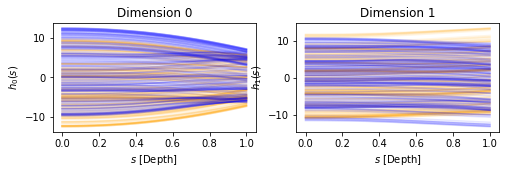

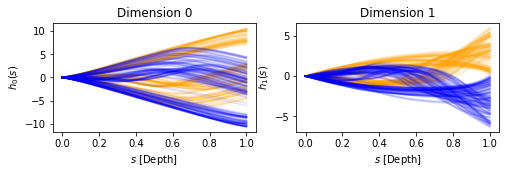

In [10]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory[:,:,:2], yn[::10], len(X)//10)
plot_2D_depth_trajectory(s_span, trajectory[:,:,2:4], yn[::10], len(X)//10)

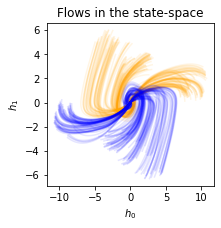

In [12]:
# Trajectories in the state-space
plot_2D_state_space(trajectory[:,:,-2:], yn[::10], len(X)//10)

Let us now train a higher--order model, e.g. 10th order, on the same task

### Showcase of Higher-Order Models (10th order Neural ODE)

Here, we introduce an integral regularization term leveraing the [generalized adjoint](https://arxiv.org/abs/2003.08063) for Neural ODEs.

In [13]:
class IntegralWReg(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self, s, x):
        loss = 1e-6*torch.abs(self.f(x)).sum(1) 
        return loss

With `torchdyn`, going beyond orders 1 and 2 is easy. Simply use the `order` argument during `NeuralDE` instantiations.

In [14]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(20, 128),
        nn.Tanh(), 
        nn.Linear(128, 2))

# Neural ODE
model = NeuralDE(f, 
                 order=10,
                 solver='dopri5', 
                 sensitivity='adjoint', 
                 intloss=IntegralWReg(f)).to(device)

seq = nn.Sequential(Augmenter(1, 18, order='last'), model, nn.Linear(20,2)).to(device)

Note that the training will be slower than `order=1` Neural ODEs: higher order dynamics are often more challenging to integrate, and adaptive-step solvers will require higher NFEs.

In [15]:
# train the neural ODE
learn = Learner(seq)
trainer = pl.Trainer(min_epochs=600, max_epochs=1200)
trainer.fit(learn)
# Don't be alarmed by oscillations of the "terminal" loss (printed at every iter)! Having also an "integral" loss term, it is the sum of the two that really matters.

INFO:lightning:
   | Name               | Type         | Params
------------------------------------------------
0  | model              | Sequential   | 2 K   
1  | model.0            | Augmenter    | 0     
2  | model.1            | NeuralDE     | 2 K   
3  | model.1.defunc     | DEFunc       | 2 K   
4  | model.1.defunc.m   | Sequential   | 2 K   
5  | model.1.defunc.m.0 | Linear       | 2 K   
6  | model.1.defunc.m.1 | Tanh         | 0     
7  | model.1.defunc.m.2 | Linear       | 258   
8  | model.1.intloss    | IntegralWReg | 2 K   
9  | model.1.adjoint    | Adjoint      | 2 K   
10 | model.2            | Linear       | 42    


C:\Users\stefano\Anaconda3\lib\site-packages\pytorch_lightning\utilities\warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)
INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1

**Plots**

In [19]:
# Evaluate the data trajectories
s_span = torch.linspace(0,1,100)
X_d = seq[0](X_train[::10,:])
trajectory = model.trajectory(X_d, s_span).detach().cpu()

In [ ]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory[:,:,:2], yn[::10], len(X)//10)
plot_2D_depth_trajectory(s_span, trajectory[:,:,2:4], yn[::10], len(X)//10)
plot_2D_depth_trajectory(s_span, trajectory[:,:,4:6], yn[::10], len(X)//10)
plot_2D_depth_trajectory(s_span, trajectory[:,:,6:8], yn[::10], len(X)//10)
plot_2D_depth_trajectory(s_span, trajectory[:,:,8:10], yn[::10], len(X)//10)
plot_2D_depth_trajectory(s_span, trajectory[:,:,10:12], yn[::10], len(X)//10)
plot_2D_depth_trajectory(s_span, trajectory[:,:,12:14], yn[::10], len(X)//10)
plot_2D_depth_trajectory(s_span, trajectory[:,:,14:16], yn[::10], len(X)//10)
plot_2D_depth_trajectory(s_span, trajectory[:,:,16:18], yn[::10], len(X)//10)
plot_2D_depth_trajectory(s_span, trajectory[:,:,18:20], yn[::10], len(X)//10)

In [ ]:
# Trajectories in the state-space
plot_2D_state_space(trajectory[:,:,-2:], yn[::10], len(X)//10)